In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import Utils.dataframe as dataframe_helper
import Utils.learning as learning
import mlflow
import spacy
from sklearn.model_selection import train_test_split

In [3]:
experiment_name = "Count By Word Model"
pd.set_option('display.max_columns', None)
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='../mlruns/746529752663207522', creation_time=1677145153271, experiment_id='746529752663207522', last_update_time=1677145153271, lifecycle_stage='active', name='Count By Word Model', tags={}>

## Feature Engineering

In [4]:
def feature_engineering_one_hot(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL one hot encoding
    fakeWordOneHot = []
    nonFakeWordOneHot = []

    for content in df['reviewContent']:
        fakeOneHot = ''
        nonFakeOneHot = ''
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)

        for word in fake_words:
            if word in words:
                fakeOneHot += '1'
            else:
                fakeOneHot += '0'

        for word in non_fake_words:
            if word in words:
                nonFakeOneHot += '1'
            else:
                nonFakeOneHot += '0'
                
        fakeWordOneHot.append(fakeOneHot)
        nonFakeWordOneHot.append(nonFakeOneHot)
    
    result = pd.DataFrame()
    result['fakeWordsOneHot'] = fakeWordOneHot
    result['nonFakeWordsOneHot'] = nonFakeWordOneHot

    result = dataframe_helper.onehot(result, 'fakeWordsOneHot', fake_words, 'fake')
    result = dataframe_helper.onehot(result, 'nonFakeWordsOneHot', non_fake_words, 'non fake')
    
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

In [5]:
def feature_engineering_one_hot_cvect(df:pd.DataFrame) -> pd.DataFrame:
    with open("../Data/top_word/word_from_cVect.txt", "r") as f:
        bag_of_words = dataframe_helper.string_to_list(f.read())
  
    # KL one hot encoding
    WordOneHot = []

    for content in df['reviewContent']:
        oneHot = ''
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)

        for word in bag_of_words:
            if word in words:
                oneHot += '1'
            else:
                oneHot += '0'
                
        WordOneHot.append(oneHot)
    
    result = pd.DataFrame()
    result['WordsOneHot'] = WordOneHot

    result = dataframe_helper.onehot(result, 'WordsOneHot', bag_of_words, '')
    
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result

In [6]:
def feature_engineering_word_count(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL word count
    fakeWordsCount = []
    nonFakeWordsCount = []

    for content in df['reviewContent']:
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)
        fakeCount = 0
        nonFakeCount = 0
        for word in words:
            if word in fake_words:
                fakeCount += 1
            elif word in non_fake_words:
                nonFakeCount += 1
        fakeWordsCount.append(fakeCount)
        nonFakeWordsCount.append(nonFakeCount)

    result = pd.DataFrame()
    result['fakeWordsCount'] = fakeWordsCount
    result['nonFakeWordsCount'] = nonFakeWordsCount
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']
    
    return result
    

In [7]:
def feature_engineering_count_by_word(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL one hot encoding
    fakeWordOneHot = []
    nonFakeWordOneHot = []

    for content in df['reviewContent']:
        fakeOneHot = ''
        nonFakeOneHot = ''
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)
        words = Counter(words)
        for word in fake_words:
            if word in words:
                fakeOneHot += str(words[word])
            else:
                fakeOneHot += '0'

        for word in non_fake_words:
            if word in words:
                nonFakeOneHot += str(words[word])
            else:
                nonFakeOneHot += '0'
                
        fakeWordOneHot.append(fakeOneHot)
        nonFakeWordOneHot.append(nonFakeOneHot)
    
    result = pd.DataFrame()
    result['fakeWordsOneHot'] = fakeWordOneHot
    result['nonFakeWordsOneHot'] = nonFakeWordOneHot

    result = dataframe_helper.onehot(result, 'fakeWordsOneHot', fake_words, 'fake')
    result = dataframe_helper.onehot(result, 'nonFakeWordsOneHot', non_fake_words, 'non fake')
    
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

In [8]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

In [9]:
def feature_engineering_cVect(df:pd.DataFrame) -> pd.DataFrame:
    cVect = CountVectorizer(stop_words='english', preprocessor=preprocess_text, token_pattern = '[a-zA-Z0-9]+')
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)
    # cVect = CountVectorizer()
    cVect.fit(df['reviewContent'].iloc[:8*len(df)//10])
    dtv = cVect.transform(df['reviewContent'])
    dtv = dtv.toarray()
    result =  pd.DataFrame(dtv, columns = [f'{colunm}' for colunm in cVect.get_feature_names()])
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']
    return result
    

In [10]:
def feature_engineering_tfidfVect(df:pd.DataFrame) -> pd.DataFrame:
    tfidfVect = CountVectorizer(stop_words='english', preprocessor=preprocess_text, token_pattern = '[a-zA-Z0-9]+')
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)
    # tfidfVect = CountVectorizer()
    tfidfVect.fit(df['reviewContent'].iloc[:8*len(df)//10])
    dtv = tfidfVect.transform(df['reviewContent'])
    dtv = dtv.toarray()
    result =  pd.DataFrame(dtv, columns = [f'{colunm}' for colunm in tfidfVect.get_feature_names()])
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']
    return result

In [11]:
def feature_engineering_combine(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    nlp = spacy.load("en_core_web_sm")

    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())

    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL one hot encoding
    fakeWordOneHot = []
    nonFakeWordOneHot = []

    # linguistic features
    number_of_words = []
    number_of_verbs = []
    number_of_clauses = []
    average_word_length = []
    pausality = []
    number_of_passive_voice = []
    number_of_self_and_group_reference_terms_used = []
    expressiveness_ratio = []
    lexical_diversity = []
    content_word_diversity = []
    typo_ratio = []
    number_of_spatio_temporal_words = []
    
    for content in df['reviewContent']:
        fakeOneHot = ''
        nonFakeOneHot = ''
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)

        for word in fake_words:
            if word in words:
                fakeOneHot += '1'
            else:
                fakeOneHot += '0'

        for word in non_fake_words:
            if word in words:
                nonFakeOneHot += '1'
            else:
                nonFakeOneHot += '0'
                
        fakeWordOneHot.append(fakeOneHot)
        nonFakeWordOneHot.append(nonFakeOneHot)
        
        doc = nlp(content)
        if len(doc) != 0:
            number_of_words.append(len(doc))
            number_of_verbs.append(len([token for token in doc if token.pos_ == "VERB"]))
            number_of_clauses.append(len([token for token in doc if token.dep_ == "ROOT"]))
            average_word_length.append(sum([len(token) for token in doc]) / len(doc))
            pausality.append(len([token for token in doc if token.pos_ == "PUNCT"]) / len(doc))
            number_of_passive_voice.append(len([token for token in doc if token.dep_ == "nsubjpass"]))
            number_of_self_and_group_reference_terms_used.append(len([token for token in doc if token.dep_ == "nsubj"]))
            expressiveness_ratio.append(len([token for token in doc if token.pos_ == "ADJ"]) / len(doc))
            lexical_diversity.append(len(set([token.text for token in doc])) / len(doc))
            content_word_diversity.append(len(set([token.text for token in doc if token.pos_ != "PUNCT"])) / len(doc))
            typo_ratio.append(len([token for token in doc if token.pos_ == "SYM"]) / len(doc))
            number_of_spatio_temporal_words.append(len([token for token in doc if token.pos_ == "ADV"]))
        else:
            number_of_words.append(0)
            number_of_verbs.append(0)
            number_of_clauses.append(0)
            average_word_length.append(0)
            pausality.append(0)
            number_of_passive_voice.append(0)
            number_of_self_and_group_reference_terms_used.append(0)
            expressiveness_ratio.append(0)
            lexical_diversity.append(0)
            content_word_diversity.append(0)
            typo_ratio.append(0)
            number_of_spatio_temporal_words.append(0)

    result = pd.DataFrame()
    result['fakeWordsOneHot'] = fakeWordOneHot
    result['nonFakeWordsOneHot'] = nonFakeWordOneHot
    result = dataframe_helper.onehot(result, 'fakeWordsOneHot', fake_words, 'fake')
    result = dataframe_helper.onehot(result, 'nonFakeWordsOneHot', non_fake_words, 'non fake')
    result['number_of_words'] = number_of_words
    result['number_of_verbs'] = number_of_verbs
    result['number_of_clauses'] = number_of_clauses
    result['average_word_length'] = average_word_length
    result['pausality'] = pausality
    result['number_of_passive_voice'] = number_of_passive_voice
    result['number_of_self_and_group_reference_terms_used'] = number_of_self_and_group_reference_terms_used
    result['expressiveness_ratio'] = expressiveness_ratio
    result['lexical_diversity'] = lexical_diversity
    result['content_word_diversity'] = content_word_diversity
    result['typo_ratio'] = typo_ratio
    result['number_of_spatio_temporal_words'] = number_of_spatio_temporal_words  

    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

In [12]:
def feature_engineering_linguistic(df:pd.DataFrame) -> pd.DataFrame:
    nlp = spacy.load("en_core_web_sm")
    
    number_of_words = []
    number_of_verbs = []
    number_of_clauses = []
    average_word_length = []
    pausality = []
    number_of_passive_voice = []
    number_of_self_and_group_reference_terms_used = []
    expressiveness_ratio = []
    lexical_diversity = []
    content_word_diversity = []
    typo_ratio = []
    number_of_spatio_temporal_words = []
    
    for content in df['reviewContent']:
        doc = nlp(content)
        if len(doc) != 0:
            number_of_words.append(len(doc))
            number_of_verbs.append(len([token for token in doc if token.pos_ == "VERB"]))
            number_of_clauses.append(len([token for token in doc if token.dep_ == "ROOT"]))
            average_word_length.append(sum([len(token) for token in doc]) / len(doc))
            pausality.append(len([token for token in doc if token.pos_ == "PUNCT"]) / len(doc))
            number_of_passive_voice.append(len([token for token in doc if token.dep_ == "nsubjpass"]))
            number_of_self_and_group_reference_terms_used.append(len([token for token in doc if token.dep_ == "nsubj"]))
            expressiveness_ratio.append(len([token for token in doc if token.pos_ == "ADJ"]) / len(doc))
            lexical_diversity.append(len(set([token.text for token in doc])) / len(doc))
            content_word_diversity.append(len(set([token.text for token in doc if token.pos_ != "PUNCT"])) / len(doc))
            typo_ratio.append(len([token for token in doc if token.pos_ == "SYM"]) / len(doc))
            number_of_spatio_temporal_words.append(len([token for token in doc if token.pos_ == "ADV"]))
        else:
            number_of_words.append(0)
            number_of_verbs.append(0)
            number_of_clauses.append(0)
            average_word_length.append(0)
            pausality.append(0)
            number_of_passive_voice.append(0)
            number_of_self_and_group_reference_terms_used.append(0)
            expressiveness_ratio.append(0)
            lexical_diversity.append(0)
            content_word_diversity.append(0)
            typo_ratio.append(0)
            number_of_spatio_temporal_words.append(0)

    result = pd.DataFrame()
    result['number_of_words'] = number_of_words
    result['number_of_verbs'] = number_of_verbs
    result['number_of_clauses'] = number_of_clauses
    result['average_word_length'] = average_word_length
    result['pausality'] = pausality
    result['number_of_passive_voice'] = number_of_passive_voice
    result['number_of_self_and_group_reference_terms_used'] = number_of_self_and_group_reference_terms_used
    result['expressiveness_ratio'] = expressiveness_ratio
    result['lexical_diversity'] = lexical_diversity
    result['content_word_diversity'] = content_word_diversity
    result['typo_ratio'] = typo_ratio
    result['number_of_spatio_temporal_words'] = number_of_spatio_temporal_words  
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

## Make train dataset

In [13]:
df = dataframe_helper.load_data()
df = dataframe_helper.data_cleaning(df)
# df = feature_engineering_one_hot_cvect(df)
# df = feature_engineering_cVect(df)
# df = feature_engineering_one_hot(df)
# df = feature_engineering_word_count(df)
# df = feature_engineering_count_by_word(df,50)
# df = feature_engineering_linguistic(df)
# df = feature_engineering_combine(df)

In [14]:
# over_sampling_df = dataframe_helper.over_sampling(df=df, target='flagged')
# under_sampling_df = dataframe_helper.under_sampling(df=df, target='flagged')

In [15]:
over_sampling_df = dataframe_helper.over_sampling(df=df, target='flagged')
over_sampling_df = feature_engineering_cVect(over_sampling_df)
flagged = over_sampling_df['flagged'] 
reviewContent = over_sampling_df['reviewContent']
over_sampling_df = over_sampling_df.drop(['reviewContent', 'flagged'], axis=1)
over_sampling_df = over_sampling_df.astype(int)
over_sampling_df = over_sampling_df.apply(lambda x: x/x)
over_sampling_df = over_sampling_df.fillna(0)
over_sampling_df['flagged'] = flagged
over_sampling_df['reviewContent'] = reviewContent

# under_sampling_df = dataframe_helper.under_sampling(df=df, target='flagged')
# under_sampling_df = feature_engineering_cVect(under_sampling_df)
# flagged = under_sampling_df['flagged'] 
# reviewContent = under_sampling_df['reviewContent']
# under_sampling_df = under_sampling_df.drop(['reviewContent', 'flagged'], axis=1)
# under_sampling_df = under_sampling_df.astype(int)
# under_sampling_df = under_sampling_df.apply(lambda x: x/x)
# under_sampling_df = under_sampling_df.fillna(0)
# under_sampling_df['flagged'] = flagged
# under_sampling_df['reviewContent'] = reviewContent

Over-Sampling Data
Over-Sampling Complete


In [ ]:
over_sampling_df

# Model 

In [16]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto', n_estimators=500)
lr = LogisticRegression(solver='liblinear', penalty ='l2' , C = 2.0)
nb = GaussianNB()

In [ ]:
learning.supervised_learning(over_sampling_df.copy(), model=rf, algorithm='Random Forest', drop_column='reviewContent', target_column='flagged')

In [ ]:
learning.supervised_learning(over_sampling_df.copy(), model=nb, algorithm='Naive Bayes', drop_column='reviewContent', target_column='flagged')

Training Logistic Regression Model
Logistic Regression Model Results
----------------------------------------
Accuracy Score : 0.8275828835774865
Precision Score : 0.7732288501519271
Recall Score : 0.928736073761045
F1 Score : 0.8438781743607645
Confusion Matrix : 
[[3752 1418]
 [ 371 4835]]


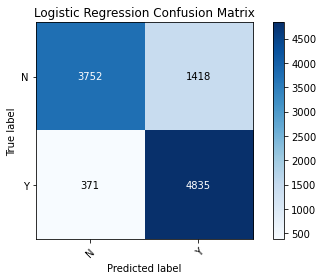

In [17]:
learning.supervised_learning(over_sampling_df.copy(), model=lr, algorithm='Logistic Regression', drop_column='reviewContent', target_column='flagged')

In [ ]:
learning.semi_supervised_learning(over_sampling_df.copy(), experiment_name, df_type='over_sampled', model=rf, threshold=0.7, iterations=7, algorithm='Random Forest', target_column='flagged')

In [ ]:
learning.semi_supervised_learning(over_sampling_df.copy(), experiment_name, df_type='over_sampled', model=nb, threshold=0.7, iterations=7, algorithm='Naive Bayes', target_column='flagged')

In [ ]:
learning.semi_supervised_learning(over_sampling_df.copy(), experiment_name, df_type='over_sampled', model=lr, threshold=0.7, iterations=7, algorithm='Logistic Regression', target_column='flagged')

In [ ]:
learning.supervised_learning(under_sampling_df.copy(), model=rf, algorithm='Random Forest', drop_column='reviewContent', target_column='flagged')

In [ ]:
learning.supervised_learning(under_sampling_df.copy(), model=nb, algorithm='Naive Bayes', drop_column='reviewContent', target_column='flagged')

In [ ]:
learning.supervised_learning(under_sampling_df.copy() , model=lr, algorithm='Logistic Regression', drop_column='reviewContent', target_column='flagged')

In [ ]:
learning.semi_supervised_learning(under_sampling_df.copy(), experiment_name, df_type='over_sampled', model=rf, threshold=0.7, iterations=7, algorithm='Random Forest', target_column='flagged')

In [ ]:
learning.semi_supervised_learning(under_sampling_df.copy(), experiment_name, df_type='over_sampled', model=nb, threshold=0.7, iterations=7, algorithm='Naive Bayes', target_column='flagged')

In [ ]:
learning.semi_supervised_learning(under_sampling_df.copy(), experiment_name, df_type='over_sampled', model=lr, threshold=0.7, iterations=7, algorithm='Logistic Regression', target_column='flagged')